## Import libraries

In [18]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import cv2
import keras
from keras.models import Model
from keras.applications.resnet50 import ResNet50
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, UpSampling2D, Conv2D, MaxPooling2D, Concatenate, Activation

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Functions

In [19]:
def rle_decode(mask_rle, shape=(1280, 1918, 1)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)

    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths    
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
        
    img = img.reshape(shape)
    return img

In [20]:
def keras_generator(gen_df, batch_size):
    while True:
        x_batch = []
        y_batch = []
        
        for i in range(batch_size):
            img_name, mask_rle = gen_df.sample(1).values[0]
            img = cv2.imread('/content/drive/My Drive/data/train/{}'.format(img_name))
            mask = rle_decode(mask_rle)
            
            img = cv2.resize(img, (256, 256))
            mask = cv2.resize(mask, (256, 256))
            
            
            x_batch += [img]
            y_batch += [mask]

        x_batch = np.array(x_batch) / 255.
        y_batch = np.array(y_batch)

        yield x_batch, np.expand_dims(y_batch, -1)

## Loading data

In [21]:
df = pd.read_csv('/content/drive/My Drive/data/train_masks.csv')
df.shape

(5088, 2)

In [22]:
train_df = df[:4000]
val_df = df[4000:]

In [23]:
img_name, mask_rle = train_df.iloc[4]

img = cv2.imread('/content/drive/My Drive/data/train/{}'.format(img_name))
mask = rle_decode(mask_rle)

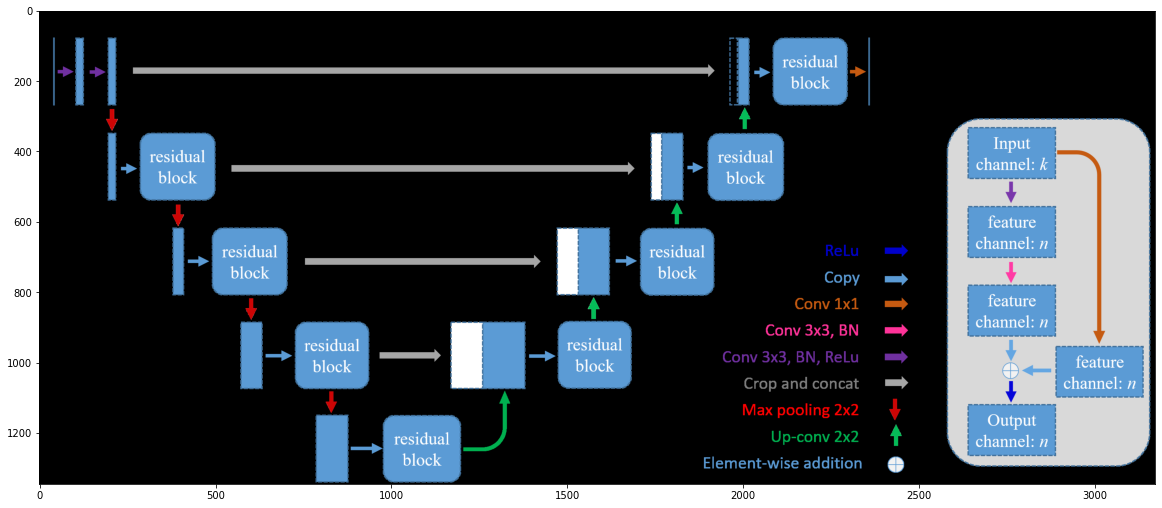

In [24]:
seg_png = cv2.imread('/content/drive/My Drive/unet_resnet_strucutre_new.png')
plt.figure(figsize=(20,20))
plt.imshow(seg_png[..., [2,1,0]])
plt.show()

In [25]:
# create the base pre-trained model
base_model = ResNet50(weights='imagenet', input_shape=(256,256,3), include_top=False)
 
base_out = base_model.output

In [26]:
base_model.summary(line_length=150)

Model: "resnet50"
______________________________________________________________________________________________________________________________________________________
Layer (type)                                     Output Shape                     Param #           Connected to                                      
input_2 (InputLayer)                             [(None, 256, 256, 3)]            0                                                                   
______________________________________________________________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)                        (None, 262, 262, 3)              0                 input_2[0][0]                                     
______________________________________________________________________________________________________________________________________________________
conv1_conv (Conv2D)                              (None, 128, 128, 64)       

In [28]:
conv1 = base_model.get_layer('conv1_relu').output
conv2 = base_model.get_layer('conv2_block1_out').output
conv3 = base_model.get_layer('conv3_block1_out').output
conv4 = base_model.get_layer('conv4_block1_out').output
conv5 = base_model.get_layer('conv5_block1_out').output

inp = base_model.get_layer('input_2').output

In [29]:
up1 = UpSampling2D(2, interpolation='nearest')(conv5)
conc_1 = Concatenate()([up1, conv4])
conv_conc_1 = Conv2D(256, (3, 3), padding='same')(conc_1)
conv_conc_1 = Activation('relu')(conv_conc_1)

up2 = UpSampling2D(2, interpolation='nearest')(conv_conc_1)
conc_2 = Concatenate()([up2, conv3])
conv_conc_2 = Conv2D(128, (3, 3), padding='same')(conc_2)
conv_conc_2 = Activation('relu')(conv_conc_2)

up3 = UpSampling2D(2, interpolation='nearest')(conv_conc_2)
conc_3 = Concatenate()([up3, conv2])
conv_conc_3 = Conv2D(64, (3, 3), padding='same')(conc_3)
conv_conc_3 = Activation('relu')(conv_conc_3)

up4 = UpSampling2D(2, interpolation='nearest')(conv_conc_3)
conc_4 = Concatenate()([up4, conv1])
conv_conc_4 = Conv2D(32, (3, 3), padding='same')(conc_4)
conv_conc_4 = Activation('relu')(conv_conc_4)

up5 = UpSampling2D(2, interpolation='nearest')(conv_conc_4)
conv_conc_5 = Conv2D(3, (3, 3), padding='same')(up5)
conv_conc_5 = Activation('sigmoid')(conv_conc_5)

In [30]:
model = Model(inputs=base_model.input, outputs=conv_conc_5)

In [31]:
best_w = keras.callbacks.ModelCheckpoint('resnet_best.h5',
                                monitor='val_loss',
                                verbose=0,
                                save_best_only=True,
                                save_weights_only=True,
                                mode='auto',
                                period=1)

last_w = keras.callbacks.ModelCheckpoint('resnet_last.h5',
                                monitor='val_loss',
                                verbose=0,
                                save_best_only=False,
                                save_weights_only=True,
                                mode='auto',
                                period=1)


callbacks = [best_w, last_w]



adam = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.99, epsilon=1e-08, decay=0.0)


model.compile(adam, 'binary_crossentropy')

In [32]:
batch_size = 8
model.fit(keras_generator(train_df, batch_size),
              steps_per_epoch=100,
              epochs=15,
              verbose=1,
              callbacks=callbacks,
              validation_data=keras_generator(val_df, batch_size),
              validation_steps=50,
              class_weight=None,
              max_queue_size=10,
              workers=1,
              use_multiprocessing=False,
              shuffle=True,
              initial_epoch=0)

Epoch 1/15
100/100 [==============================] - 131s 1s/step - loss: 0.1514 - val_loss: 3.7437
Epoch 2/15
100/100 [==============================] - 112s 1s/step - loss: 0.0223 - val_loss: 4.8580
Epoch 3/15
100/100 [==============================] - 114s 1s/step - loss: 0.0168 - val_loss: 5.1213
Epoch 4/15
100/100 [==============================] - 97s 973ms/step - loss: 0.0143 - val_loss: 6.8540
Epoch 5/15
100/100 [==============================] - 88s 882ms/step - loss: 0.0138 - val_loss: 2.7251
Epoch 6/15
100/100 [==============================] - 79s 799ms/step - loss: 0.0132 - val_loss: 0.5346
Epoch 7/15
100/100 [==============================] - 73s 732ms/step - loss: 0.0116 - val_loss: 0.2031
Epoch 8/15
100/100 [==============================] - 73s 735ms/step - loss: 0.0106 - val_loss: 0.0836
Epoch 9/15
100/100 [==============================] - 68s 681ms/step - loss: 0.0102 - val_loss: 0.0398
Epoch 10/15
100/100 [==============================] - 72s 722ms/step - loss: 0

In [33]:
for x, y in keras_generator(train_df, 8):
    break

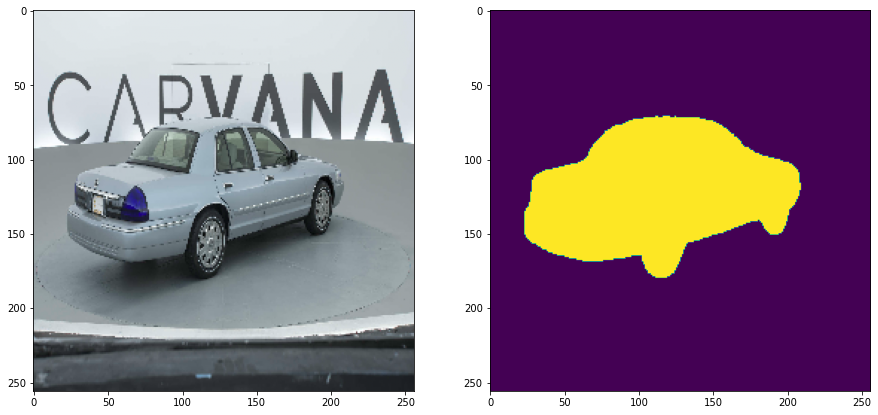

In [34]:
pred = model.predict(x)

im_id = 5
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 15))
axes[0].imshow(x[im_id])
axes[1].imshow(pred[im_id, ..., 0] >0.5)

plt.show()